<a href="https://colab.research.google.com/github/madaan/reasoning-tutorial/blob/main/Part_1_Language_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.7 MB/s eta 0:00:00


In [ ]:
from ipywidgets import interact, widgets


In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch

model_name = "gpt2"  # You can also use other model names like "bert-base-uncased", "openai-gpt", etc.
model = AutoModelWithLMHead.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Understanding Language Models

Language models provide a probabilistic framework to understand and generate sequences of words. At their core, they estimate the probability distribution over word sequences.

### Classical Formulation

Traditionally, the joint probability of a sequence of words $s_1, s_2, \dots, s_n$ is decomposed using the chain rule of probability:

$$ P(s_1, s_2, \dots, s_n) = P(s_1) \times P(s_2 | s_1) \times P(s_3 | s_1, s_2) \times \dots \times P(s_n | s_1, \dots, s_{n-1}) $$

Each term $P(s_i | s_1, \dots, s_{i-1})$ represents the conditional probability of word $s_i$ given its preceding words.

### GPT-2 and Next Token Prediction

Models like GPT-2 (Generative Pre-trained Transformer) operationalize this classical idea in the context of deep learning. Given a sequence of words, GPT-2 estimates the conditional probability distribution of the next word in the sequence, effectively predicting $P(s_{n+1} | s_1, s_2, \dots, s_n)$.

In this demonstration, we'll use GPT-2 to estimate the likelihood of entire sentences based on the joint probability of their tokens.


In [ ]:
def average_log_probability(sentence):
    input_ids = tokenizer.encode(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    # Get the token probabilities
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # Compute joint log probability of the sentence
    joint_log_prob = 0.0
    for idx, token_id in enumerate(input_ids[0][1:]):
        joint_log_prob += torch.log(probs[0, idx, token_id])

    # Return average log-probability per token
    return joint_log_prob / len(input_ids[0])


def compare_sentences(sentence1, sentence2):
    avg_log_prob1 = torch.exp(average_log_probability(sentence1))
    avg_log_prob2 = torch.exp(average_log_probability(sentence2))

    print(f"\nAverage Probability of Sentence 1 ('{sentence1}'): {avg_log_prob1:.4f}")
    print(f"\nAverage Probability of Sentence 2 ('{sentence2}'): {avg_log_prob2:.4f}")

    if avg_log_prob1 > avg_log_prob2:
        print(f"Sentence 1 ('{sentence1}') is more common.")
    elif avg_log_prob2 > avg_log_prob1:
        print(f"Sentence 2 ('{sentence2}') is more common.")
    else:
        print("Both sentences are equally common.")


In [ ]:
text_layout = widgets.Layout(width='800px', height='40px') # Adjust width and height as desired

interact(compare_sentences,
         sentence1=widgets.Textarea(value='The cat sat on the mat.', layout=text_layout),
         sentence2=widgets.Textarea(value='The mat sat on the cat.', layout=text_layout));


interactive(children=(Textarea(value='The cat sat on the mat.', description='sentence1', layout=Layout(height=…

## Predicting the Next Word

The decomposition of language modeling objective using the chain rule leads to next word prediction. From what we know based on publicly available information, all modern language models are essentially this idea at scale.

### Objective:

The goal here is to predict the next word in a sequence (or prefix) using GPT-2. We aim to:

1. Tokenize a given prefix.
2. Use GPT-2 to predict the likelihood of potential next words.
3. Display the top 5 most likely next words along with their associated probabilities.


- Let's play with this function!

In [ ]:
def get_top_5_words(suffix):
    input_ids = tokenizer.encode(suffix, return_tensors="pt")
    with torch.no_grad():
        outputs = model(input_ids)
        predictions = outputs.logits

    # Get the probabilities using the softmax function
    probs = softmax(predictions[0, -1, :])

    # Get the top 5 predicted token IDs and their corresponding probabilities
    top_5_indices = torch.topk(predictions[0, -1, :], 5).indices
    top_5_probs = probs[top_5_indices].tolist()

    # Convert token IDs to words
    top_5_words = [tokenizer.decode(idx) for idx in top_5_indices]

    return top_5_words, top_5_probs


def get_top_5_words_interactive(prefix="The future of artificial"):
    top_5_words, top_5_probs = get_top_5_words(prefix)

    print(f"Given the prefix: '{prefix}', the top 5 predicted next words and their probabilities are:")
    print("-" * 80)
    for word, prob in zip(top_5_words, top_5_probs):
        print(f"Predicted next word: '{word}' with probability: {prob:.2f}")
    print("-" * 80)


In [ ]:
def softmax(logits):
    exp_logits = torch.exp(logits - torch.max(logits))
    return exp_logits / exp_logits.sum(dim=0)


In [ ]:
interact(get_top_5_words_interactive, prefix=widgets.Textarea(value='The future of ok', layout=text_layout))


interactive(children=(Textarea(value='The future of ok', description='prefix', layout=Layout(height='40px', wi…

<function __main__.get_top_5_words_interactive(prefix='The future of artificial')>

#### Note: the predictions can be very different depending on whether you end your sentence with a space or not! This is because of tokenization.

- Try tokenizing "artificial" and " artificial" -- they are different tokens! When you end a sentence with a space, the model is being asked to predict what comes after a space, a sequence only seen when tons of whitespace was being processed.

- See [this discussion](https://discuss.huggingface.co/t/bpe-tokenizers-and-spaces-before-words/475) for some more context.

tokenizer.encode(" artificial", return_tensors="pt")

tokenizer.encode("artificial", return_tensors="pt")

In [ ]:
tokenizer.encode("The future of", return_tensors="pt")

tensor([[ 464, 2003,  286]])

## Extending the Idea of Next Token Prediction


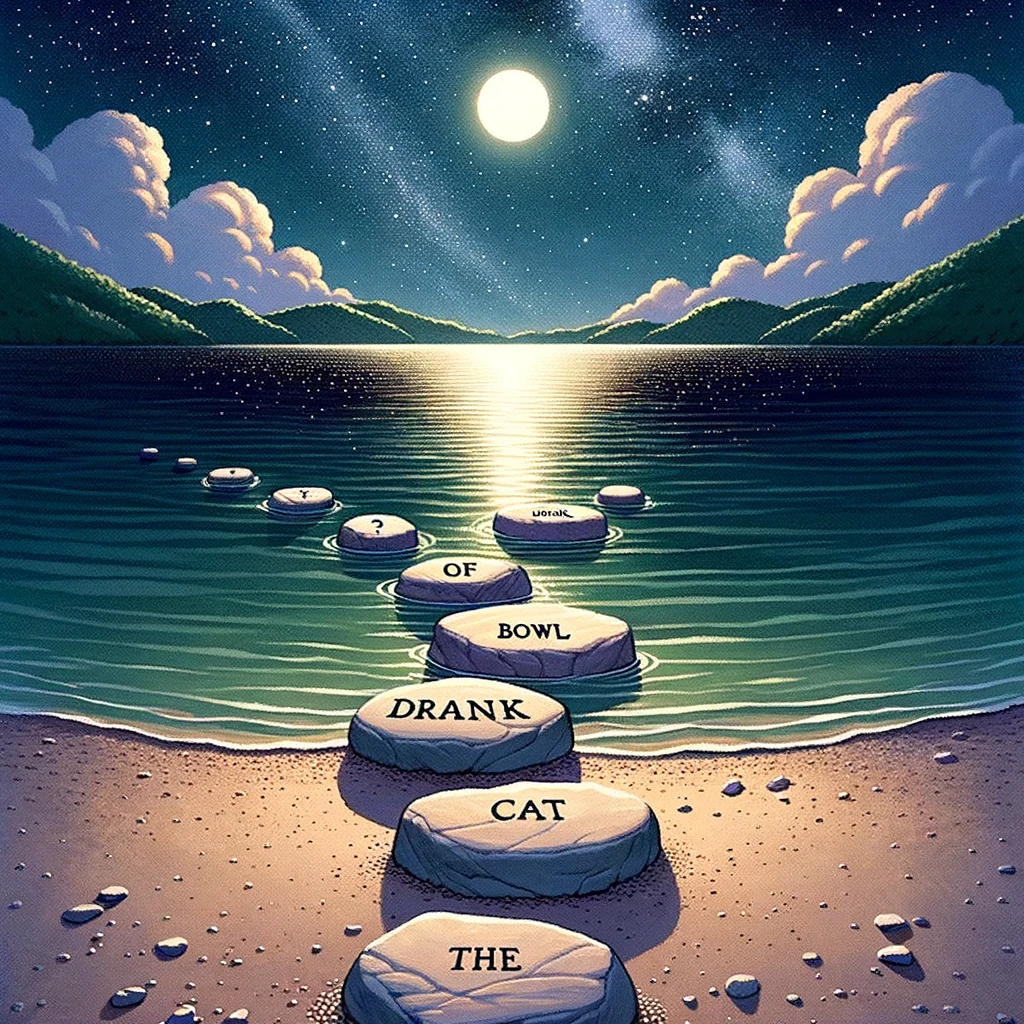
Language models, in their essence, predict the likelihood of a sequence of words. A fundamental operation in this prediction process is estimating the next word in a sequence. While this might seem like a simple prediction, the implications and extensions of this technique are profound.

### Chained Predictions for Sequence Generation:

The principle of next token prediction can be extended iteratively to generate longer textual sequences:

1. **Iterative Application**: Start with an initial word or phrase. Predict the next most likely word. Append this word to the sequence. Use this new sequence to predict the subsequent word. This process can be repeated indefinitely, generating text of any desired length.

2. **Joint Probability Decomposition**: The joint probability of a sequence is decomposed using the chain rule of probability. This means the probability of a sequence is the product of the conditional probabilities of each word given the preceding words. By maximizing the likelihood at each step, we're essentially choosing the most probable next word.

3. **Diverse Pathways**: While the most probable next word is a common choice in many applications, there's a vast space of slightly less probable words that can lead to diverse and meaningful sequences. This highlights the non-deterministic nature of language and the many possible continuations for any given prefix.

### The Underlying Science:

This technique is rooted in the probabilistic nature of language. Words don't appear in isolation; their occurrence depends on the context provided by preceding words. By modeling these dependencies, language models capture the essence of linguistic structures. The next token prediction, in particular, leverages these captured structures to make informed guesses about upcoming words.

Furthermore, the iterative application of this technique to generate text mirrors the cognitive processes humans might employ during speech or writing. Just as we plan our next words based on what we've already said or written, the model extends sequences based on its prior predictions, showcasing a machine-based reflection of human linguistic generation.


In [ ]:
from ipywidgets import interact, widgets, Button, HBox, VBox, Layout, Output
from IPython.display import display, clear_output


In [ ]:
class InteractiveGenerator:
    def __init__(self, prefix: str):
        self.prefix = prefix
        self.output = Output()
        self.history = []  # Store the history of chosen words

        # Create initial display
        self.display_choices(self.prefix)

    def display_choices(self, prefix):
        # Get top 5 predictions
        top_5_words, _ = get_top_5_words(prefix)

        button_styles = ['success', 'info', 'warning', 'danger', 'primary']
        buttons = [widgets.Button(description=word, layout=Layout(width='150px', height='40px'), button_style=button_styles[i]) for i, word in enumerate(top_5_words)]

        # Add on_click event to buttons
        for btn in buttons:
            btn.on_click(self.on_button_click)

        # Display the current prefix, history, and choice buttons
        with self.output:
            clear_output(wait=True)
            print(f"Current prefix: {prefix}\n")

            # Display the history with arrows
            if self.history:
                print("History:")
                print(" -> ".join(self.history))
                print("\n")

            print("Choose the next word:")
            display(HBox(buttons))

    def on_button_click(self, btn):
        # Update prefix and display next choices
        self.prefix += " " + btn.description
        self.history.append(btn.description)  # Update the history
        self.display_choices(self.prefix)

# Instantiate and display the interactive demo
gen = InteractiveGenerator("The cat drank a bowl of")
display(gen.output)


Output()